In [1]:
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8/
!export CUDA_DIR="/usr/local/cuda-11.8/"
!export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
import tensorflow as tf
import tensorflow.keras as keras


gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import os

2022-11-13 00:50:15.070049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 00:50:15.163623: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 00:50:15.560102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/home/pedro/miniconda3/envs/ml2/lib/:/usr/local/cuda-11.8/lib64/lib
2022-11-13 00:50:15.560143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2022-11-13 00:50:16.190372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:16.190605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:16.194245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:16.194448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:16.194639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random

In [4]:
!wget https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [5]:
ds_img = tfds.load("coil100", split=['train'])

IMG_H = 128
IMG_W = 128
IMG_CHANNELS = 3

EXPERIMENT_VERSION = "v3"

BATCH_SIZE = 25


2022-11-13 00:50:16.888986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 00:50:17.000821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:17.001027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 00:50:17.001205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
images = []
def gen():
    for x in ds_img:
        for y in x:
            yield y["image"]
        
output_signature=tf.TensorSpec(shape=(IMG_H, IMG_W, IMG_CHANNELS), dtype=tf.uint8)
dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)

In [7]:
def normalize(image, probs=False):
    a = (tf.cast(image, tf.float32) - 127.5) if not probs else tf.cast(image, tf.float32)
    return a / 127.5

def denormalize(image, cast=False):
    # return image
    if cast:
        return tf.cast(tf.clip_by_value(tf.cast(tf.cast(image, tf.float32) * 127.5 + 127.5, np.float32), 0.0, 255.0), tf.int32)
    return tf.clip_by_value(tf.cast(tf.cast(image, tf.float32) * 127.5 + 127.5, np.float32), 0.0, 255.0)

In [8]:
# mnist = tf.keras.datasets.fashion_mnist


# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train/255.0
# x_test = x_test/255.0

TEST_SAMPLES = 25

x_test = dataset.take(TEST_SAMPLES).cache()
x_train = dataset.skip(TEST_SAMPLES)

In [9]:
x_test_samples = np.array([y for y in list(x_test.take(4))])

2022-11-13 00:50:17.789642: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-13 00:50:17.789748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(2, 4)


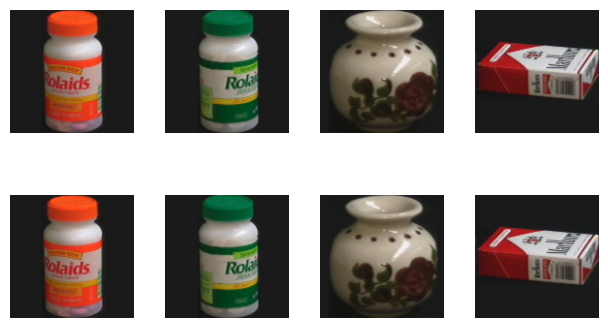

In [10]:
def print_validation(fn=lambda x:x, save=False, path="./"):
    random.seed(10)
    rows = 4
    cols = 2

    rand = zip(x_test_samples, fn(x_test_samples))
    n = np.vstack((x_test_samples,fn(x_test_samples)))
    print((cols, rows))

    plt.figure(figsize=(rows * 2, cols * 2))
    for i in range(n.shape[0]):
        x = n[i,:,:,:]
        plt.subplot(cols, rows, i+1)
        plt.imshow(tf.cast(x, np.uint8))
        plt.axis('off')
    plt.subplots_adjust(wspace = 0, hspace = 0.5)
    if save:
        plt.savefig(path)
    plt.show()
    
print_validation(lambda x: denormalize(normalize(x)))

## Experiments

In [11]:
import json

test_results_file = "./testresults.txt"

class Experiment:
    def __init__(self):
        self.encoder = ()
        self.decoder = ()
        self.use_denorm = False
        self.all_attention = False
        self.use_batch_norm = False
        self.activation = "tanh"
        
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
    
    def set_auto_encoder_filters(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        return self
        
    def with_denorm(self, use_denorm):
        self.use_denorm = use_denorm
        return self
        
    def with_attention(self, all_a=True):
        self.all_attention = all_a
        return self
        
    def with_batch_norm(self, use_batch=False):
        self.use_batch_norm = use_batch
        return self
    
    def with_activation(self, activation="tanh"):
        self.activation = activation
        return self
    
    def get_name(self):
        return "k".join(map(lambda x:str(x), self.encoder)) + "-" + "k".join(map(lambda x:str(x), self.decoder)) \
            + ("_idenorm" if self.use_denorm else "_inorm") + \
            ("_attn" if self.all_attention else "") + \
            ("_batch_norm" if self.use_batch_norm else "_spectral") +\
            (f"_{self.activation}")
    
    def __repr__(self):
        return str(self.toJSON())
    
    def __str__(self):
        return str(self.toJSON())
    
    def create_model(self):
        enc_conf = self.encoder
        dec_conf = self.decoder

        use_attention = self.all_attention
        use_batch_norm = self.use_batch_norm

        return AutoEncoder(enc_conf, dec_conf, use_attention, use_batch_norm, self.activation)
    
    def save(self):
        f = open(test_results_file, "a")
        f.write(self.get_name() + "\n")
        f.close()
  

all_filters = [
    ([32,64,128,256,512], [256,128,64,32]),
    ([16,32,64,128,512], [256,64,32,16]), # best
    ([512,128,64,32,16], [32,64,128,512]),
    ([4,8,32,128,512], [128,32,8,4])
]
experiments = []
if os.path.exists(test_results_file):
    os.remove(test_results_file)
for encf, decf in all_filters:
    for use_den in [True, False]: # both equally good
        for with_att in [False]: # true best
            for with_batch_norm in [False]: # false best
                for activation in ["sigmoid", "tanh"]:
                    experiments.append(Experiment()
                        .set_auto_encoder_filters(encf, decf)
                        .with_denorm(use_den)
                        .with_attention(with_att)
                        .with_batch_norm(with_batch_norm)
                        .with_activation(activation)
                                      )

                    
list(map(lambda x: x.get_name(), experiments))

['32k64k128k256k512-256k128k64k32_idenorm_spectral_sigmoid',
 '32k64k128k256k512-256k128k64k32_idenorm_spectral_tanh',
 '32k64k128k256k512-256k128k64k32_inorm_spectral_sigmoid',
 '32k64k128k256k512-256k128k64k32_inorm_spectral_tanh',
 '16k32k64k128k512-256k64k32k16_idenorm_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_idenorm_spectral_tanh',
 '16k32k64k128k512-256k64k32k16_inorm_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_inorm_spectral_tanh',
 '512k128k64k32k16-32k64k128k512_idenorm_spectral_sigmoid',
 '512k128k64k32k16-32k64k128k512_idenorm_spectral_tanh',
 '512k128k64k32k16-32k64k128k512_inorm_spectral_sigmoid',
 '512k128k64k32k16-32k64k128k512_inorm_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_idenorm_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_idenorm_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_inorm_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_inorm_spectral_tanh']

In [12]:
chosen_experiment_names = [
 '32k64k128k256k512-256k128k64k32_idenorm_spectral_sigmoid',
 '32k64k128k256k512-256k128k64k32_idenorm_attn_spectral_sigmoid',
 '32k64k128k256k512-256k128k64k32_inorm_spectral_sigmoid',
 '32k64k128k256k512-256k128k64k32_inorm_spectral_tanh',
 '32k64k128k256k512-256k128k64k32_inorm_attn_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_idenorm_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_idenorm_attn_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_inorm_spectral_sigmoid',
 '16k32k64k128k512-256k64k32k16_inorm_attn_spectral_sigmoid',
 '512k128k64k32k16-32k64k128k512_idenorm_attn_spectral_sigmoid',
 '512k128k64k32k16-32k64k128k512_inorm_spectral_sigmoid',
 '512k128k64k32k16-32k64k128k512_inorm_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_idenorm_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_idenorm_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_idenorm_attn_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_idenorm_attn_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_inorm_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_inorm_spectral_tanh',
 '4k8k32k128k512-128k32k8k4_inorm_attn_spectral_sigmoid',
 '4k8k32k128k512-128k32k8k4_inorm_attn_spectral_tanh'
]

chosen_experiments = list(filter(lambda x: x.get_name() in chosen_experiment_names, experiments))
len(chosen_experiments)


11

In [13]:
experiments = chosen_experiments

In [14]:
LATENT_SIZE = 32

In [15]:
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, filters, use_batch_norm=False, activation=False):
    super(AttentionLayer, self).__init__()
    self.filters = filters
    self.activation = activation
    self.use_batch_norm = use_batch_norm
    
  def get_conv_t(self, filters, strides, use_batch_norm=False):
    conv = tf.keras.Sequential()

    if use_batch_norm:
        conv.add(layers.Conv2DTranspose(filters, 3, strides=strides, padding="same", use_bias=False))
        conv.add(layers.BatchNormalization(momentum=0.3))
    else:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2DTranspose(filters, 3, strides=strides, padding="same", use_bias=False)
        ))
        
    conv.add(layers.LeakyReLU())
    return conv
    
    
  def build(self, input_shape):
    self.in_shape = input_shape
    b, hi, wi, c = input_shape
    self.downscale1 = layers.Conv2D(tf.cast(c*4, tf.int32), 4, strides = 4)
    self.downscale2 = layers.Conv2D(tf.cast(c*2, tf.int32), 2, strides = 2)
    self.fc = self._conv(3)
    self.gc = self._conv(3)
    self.hc = self._conv(3)
    self.xc = self._conv(self.filters)
    
    
    self.o_up_channels = self._conv(self.filters)
# 
    self.upscale1 = self.get_conv_t(self.filters, 4, self.use_batch_norm)
    self.upscale2 = self.get_conv_t(self.filters, 2, self.use_batch_norm)

    self.gamma = tf.Variable([1.], name="gamma")
    self.act = layers.LeakyReLU()
    if self.use_batch_norm:
        self.norm = layers.BatchNormalization(momentum=0.3)
#     self.downsized_dims = tf.cast(hi/6, tf.int32), tf.cast(wi/6, tf.int32), c*6
    
  def _conv(self, filters, kernel=1, strides=1):
    return layers.Conv2D(filters, kernel, strides=strides, padding="same", use_bias=False)
    
  def call(self, inputs):
    ch = self.filters
    xdsh = self.in_shape
    b = xdsh[0]
    hi = xdsh[1]
    wi = xdsh[2]
    c = xdsh[3]
        
    xd = inputs
    xd = self.downscale1(xd)
    xd = self.downscale2(xd)

    xdsh = tf.shape(xd)
    b = xdsh[0]
    hi = xdsh[1]
    wi = xdsh[2]
    c = xdsh[3]

    f = self.fc(xd) # [bs, h, w, c']
    g = self.gc(xd) # [bs, h, w, c']
    h = self.hc(xd) # [bs, h, w, c]
    inputs = self.xc(inputs)
    
    f = tf.reshape(f, [-1, hi*wi, 3])
    g = tf.reshape(g, [-1, hi*wi, 3])
    h = tf.reshape(h, [-1, hi*wi, 3])

    s = tf.matmul(g, f, transpose_b=True) # # [bs, N, N]

    beta = tf.nn.softmax(s)  # attention map

    o = tf.matmul(beta, h) # [bs, N, C]
    
    o = tf.reshape(o, shape=[b, hi, wi, tf.cast(3, tf.int32)])
    o = self.upscale1(o)
    o = self.upscale2(o)
    

    x = self.gamma * o + inputs

    if self.use_batch_norm:
        x = self.norm(x)

    if self.activation:
        x = self.act(x)
        
    return x

In [16]:
y = next(iter(x_train.map(normalize).batch(1)))

print(y.shape)

enc = AttentionLayer(56, use_batch_norm=False, activation=False)(y)
print(enc.shape)

2022-11-13 00:50:18.178546: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 128, 128, 3)


2022-11-13 00:50:18.690274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-13 00:50:19.108970: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(1, 128, 128, 56)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()


def get_conv(filters, use_attention=False, use_batch_norm=False):
    conv = tf.keras.Sequential()
    if use_attention:
        conv.add(AttentionLayer(filters, use_batch_norm=use_batch_norm))
    else:
        if use_batch_norm:
            conv.add(layers.Conv2D(filters, 3, padding="same", use_bias=False))
            conv.add(layers.BatchNormalization(momentum=0.3))
        else:
            conv.add(tfa.layers.SpectralNormalization(
                layers.Conv2D(filters, 3, padding="same", use_bias=False)
            ))
        
    conv.add(layers.LeakyReLU())
    return conv

def get_conv_t(filters, use_batch_norm=False):
    conv = tf.keras.Sequential()

    if use_batch_norm:
        conv.add(layers.Conv2DTranspose(filters, 3, strides=2, padding="same", use_bias=False))
        conv.add(layers.BatchNormalization(momentum=0.3))
    else:
        conv.add(tfa.layers.SpectralNormalization(
            layers.Conv2DTranspose(filters, 3, strides=2, padding="same", use_bias=False)
        ))
        
    conv.add(layers.LeakyReLU())
    return conv
    
def get_encoder(filters=[16,64,128,256,512], use_attention=False, use_batch_norm=False):
    encoder = tf.keras.Sequential(name="encoder")
    # encoder.add(layers.GaussianDropout(0.2))
    encoder.add(get_conv(filters[0], use_batch_norm))
    for f in filters[1:]:
        encoder.add(get_conv(f, use_batch_norm=use_batch_norm))
        encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
  
    encoder.add(get_conv(filters[-1], use_attention, use_batch_norm))
    return encoder

def get_decoder(filters=[256,128, 64,16], use_attention=False, use_batch_norm=False):
    decoder = tf.keras.Sequential(name="decoder")
    
    for f in filters:
        decoder.add(get_conv_t(f, use_batch_norm=use_batch_norm))
    
    if use_attention:
        decoder.add(AttentionLayer(filters[IMG_CHANNELS]))
    decoder.add(layers.Conv2D(IMG_CHANNELS, 3, padding='same', activation='tanh'))
    return decoder

class AutoEncoder(tf.keras.Model):
  def __init__(self, encoder_conf, decoder_conf, use_attention, use_batch_norm=False, activation='tanh'):
    super(AutoEncoder, self).__init__()
    self.encoder_conf = encoder_conf
    self.decoder_conf = decoder_conf
    self.use_attention = use_attention
    self.use_batch_norm = use_batch_norm
    self.activation = activation
    
    print(f"Autoencoder: self.use_attention={self.use_attention},  self.use_batch_norm={ self.use_batch_norm} self.activation={self.activation}")

    
  def build(self, input_shape):
    self.encoder = get_encoder(self.encoder_conf, use_attention=self.use_attention, use_batch_norm=self.use_batch_norm)
    self.decoder = get_decoder(self.decoder_conf, use_attention=self.use_attention, use_batch_norm=self.use_batch_norm)
    
    self.encoder.build(input_shape=input_shape)
    
    sh = self.encoder.output_shape
    
    self.flatten = layers.Flatten()
    self.seq1 = layers.Dense(1024)
    self.reshape = layers.Reshape([*sh[1:]])
    
    self.last = layers.Conv2D(IMG_CHANNELS, 3, padding='same', activation=self.activation)
    self.inputs_dropout = layers.Dropout(0.2)

    
  def call(self, inputs):
    x = self.inputs_dropout(inputs)
    x = self.encoder(x)
    x = self.flatten(x)
    x = self.reshape(x)
    x = self.decoder(x)
    
    # x_inputs = self.conv_input(inputs)
    
    # x = self.add([x * self.gamma, x_inputs])
    # x = self.attention(x)
    x = self.last(x)
    return x

In [18]:
y = next(iter(x_train.map(normalize).batch(1)))

print(y.shape)

enc = get_encoder([16,64,128,256,512])(y)
print(enc.shape)

dec = get_decoder([256,128,64,14])(enc)

print(dec.shape)

assert y.shape == dec.shape

(1, 128, 128, 3)
(1, 8, 8, 512)


2022-11-13 00:50:19.395130: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 128, 128, 3)


## Data transormation

In [19]:
def filter_pixel(downsize_image_ratios = [1/16]):
    def fn(img):
        downsize_image_ratio = random.choice(downsize_image_ratios)
        resized_size_h = img.shape[1]
        resized_size_w = img.shape[2]
        
        # noisy = normalize(img) + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(img.shape))
        # noisy = layers.MaxPooling2D(pool_size = (8, 8), padding='same')(tf.expand_dims(img, axis=0))
        down = tf.image.resize(
            img,
            [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
            preserve_aspect_ratio=True,
            antialias=False,
            name=None)

        up = tf.image.resize(
            down,
            [resized_size_h, resized_size_w],
            preserve_aspect_ratio=True,
            antialias=False,
            name=None)

        up = tf.cast((up), img.dtype)
        return up
    return fn

def random_pixel_noise(img2, filters, patch_size, filter_fn):
    
    if (len(tf.shape(img2)) < 4):
        img2 = tf.convert_to_tensor(img2[:,:,:])
        img2 = tf.expand_dims(img2, axis=0)
    else:
        img2 = tf.convert_to_tensor(img2[:,:,:,:])

    img2_filtered = filter_fn(img2)
    
    for i in range(filters):
        assert patch_size > 0
        assert patch_size % 2 == 0
        assert patch_size < img2.shape[1]-4
        assert patch_size < img2.shape[2]-4
        
        random.seed(time.time())

        s1 = random.randint(0,img2.shape[1]-patch_size-4)
        s2 = random.randint(0,img2.shape[2]-patch_size-4)
        
        img3 = tfa.image.cutout(img2, mask_size=[patch_size,patch_size], offset= [s1,s2])
        img4 = tfa.image.cutout(img2_filtered, mask_size=[patch_size,patch_size], offset= [s1,s2])

        img2 = img3 + img2_filtered - img4
    
    return tf.squeeze(img2)

# i = iter(x_train.batch(1))
# next(i)
# next(i)
# y = next(i)
# plt.imshow(y[0])
# plt.figure()
# noisy = random_pixel_noise(y, 24, 16, filter_pixel(downsize_image_ratios = [1/1.5,1/3,1/4]))
# plt.imshow(noisy)
# norm_noisy = normalize(noisy)
# plt.figure()
# plt.imshow(denormalize(norm_noisy, cast=True))

In [20]:
# generated_images = []

# def train_get():
#    for x, y in zip(x_train, y_train):
#         x = tf.expand_dims(x, axis=2)
#         generated_images.append(y)
#         yield x

# def test_get():
#    for x in x_test:
#         x = tf.expand_dims(x, axis=2)
#         yield x

# output_signature=tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32)
noise_factor = 0.5

images = []
def gen():
    for x in ds_img:
        for y in x:
            img = y["image"]
#             print(img.shape)
            img2 = img
#             img2 = img
            yield (img, img2)
    
def norm(probs=False):
    def fn(x,y):
        return normalize(x, probs), normalize(y, probs)
    return fn
        
output_signature=(
         tf.TensorSpec(shape=(IMG_H, IMG_W, IMG_CHANNELS), dtype=tf.float32),
         tf.TensorSpec(shape=(IMG_H, IMG_W, IMG_CHANNELS), dtype=tf.float32))
dataset2 = tf.data.Dataset.from_generator(gen, output_signature=output_signature)



x_test2 = dataset2.take(TEST_SAMPLES).cache()
x_train2 = dataset2.skip(TEST_SAMPLES)

def add_noise(x,y):
    y = random_pixel_noise(y, 25, 16, filter_pixel(downsize_image_ratios = [1/1.5,1/3,1/4]))
    return y,x

# def add_noise(x):
#     return x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(IMG_H, IMG_W, IMG_CHANNELS)) 


def get_train_ds(probs=False):
    return x_train2.map(norm(probs)).map(add_noise).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#     return tf.data.Dataset.from_generator(train_get, output_signature=output_signature).map(lambda x: (x,x)).batch(BATCH_SIZE)

def get_test_ds(probs=False):
    return x_test2.map(norm(probs)).map(add_noise).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#     return tf.data.Dataset.from_generator(test_get, output_signature=output_signature).map(lambda x: (x,x)).take(100).batch(BATCH_SIZE)

In [21]:
# i = iter(get_train_ds())
# n,i = next(i)

# print(n.shape)
# print(n[0].shape)
# plt.figure()
# plt.imshow(denormalize(n[6], cast=True))

# plt.figure()
# plt.imshow(denormalize(i[6], cast=True))

In [22]:
# %tensorboard --logdir logs/minst/

## Metrics

In [23]:
class SSIM(tf.keras.metrics.Metric):

  def __init__(self, name='ssim', **kwargs):
    super(SSIM, self).__init__(name=name, **kwargs)
    self.ssim = self.add_weight(name='ssim', initializer='zeros')
    self.ep = 0.0000001

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = denormalize(y_true)
    y_pred = denormalize(y_pred)
    same = tf.math.reduce_sum(tf.image.ssim(y_true, y_true, 255.0, filter_size=3)) + self.ep
    values = (self.ep + tf.math.reduce_sum(tf.image.ssim(y_true, y_pred, 255.0, filter_size=3))) / same
    
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        sample_weight = tf.broadcast_to(sample_weight, values.shape)
        values = tf.multiply(values, sample_weight)
    self.ssim.assign(tf.reduce_sum(values))

  def result(self):
    return self.ssim

class SSIM_Multiscale(tf.keras.metrics.Metric):

  def __init__(self, name='ssim_ms', **kwargs):
    super(SSIM_Multiscale, self).__init__(name=name, **kwargs)
    self.ssim_ms = self.add_weight(name='ssim_ms', initializer='zeros')
    self.self_ssim_ms = self.add_weight(name='self_ssim_ms', initializer='zeros')
    self.ep = 0.0000001

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = denormalize(y_true)
    y_pred = denormalize(y_pred)
    same = tf.math.reduce_sum(tf.image.ssim_multiscale(y_true, y_true, 255.0, filter_size=3)) + self.ep
    values = (self.ep + tf.math.reduce_sum(tf.image.ssim_multiscale(y_true, y_pred, 255.0, filter_size=4))) / same

    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        sample_weight = tf.broadcast_to(sample_weight, values.shape)
        values = tf.multiply(values, sample_weight)
    self.ssim_ms.assign(values)
    self.self_ssim_ms.assign(same)

  def result(self):
    return self.ssim_ms

class TOP_SSIM_Multiscale(tf.keras.metrics.Metric):

  def __init__(self, name='self_ssim_ms', **kwargs):
    super(TOP_SSIM_Multiscale, self).__init__(name=name, **kwargs)
    self.self_ssim_ms = self.add_weight(name='self_ssim_ms', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = denormalize(y_true)
    values = tf.math.reduce_sum(tf.image.ssim_multiscale(y_true, y_true, 255.0, filter_size=3))

    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        sample_weight = tf.broadcast_to(sample_weight, values.shape)
        values = tf.multiply(values, sample_weight)
    self.self_ssim_ms.assign(values)

  def result(self):
    return self.self_ssim_ms


class DenormalizedMSE(tf.keras.metrics.Metric):

  def __init__(self, name='denormalized_mse', **kwargs):
    super(DenormalizedMSE, self).__init__(name=name, **kwargs)
    self.denormalized_mse = self.add_weight(name='denormalized_mse', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = denormalize(y_true)
    y_pred = denormalize(y_pred)
    self.mse = keras.losses.MeanSquaredError()

    self.denormalized_mse.assign(self.mse(y_true, y_pred))

  def result(self):
    return self.denormalized_mse

In [24]:
import shutil

for conf in experiments:    
    model_name = f'coli100_{EXPERIMENT_VERSION}_{conf.get_name()}'
    train_log_dir = f'logs/minst/{model_name}'
    if os.path.exists(train_log_dir):
        shutil.rmtree(train_log_dir, ignore_errors=True)


## Train

(2, 4)


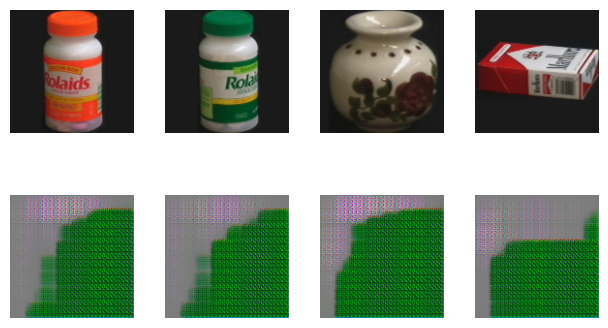

4k8k32k128k512-128k32k8k4_inorm_spectral_tanh
100/100 [==============================] - 21s 205ms/step - loss: 0.4306 - mse: 0.4306 - denormalized_mse: 6372.4746 - ssim_ms: 0.3357 - ssim: 0.4553 - val_loss: 0.4191 - val_mse: 0.4191 - val_denormalized_mse: 6813.1943 - val_ssim_ms: 0.3414 - val_ssim: 0.4422
Epoch 3/70
 84/100 [========================>.....] - ETA: 2s - loss: 0.4096 - mse: 0.4096 - denormalized_mse: 6357.1201 - ssim_ms: 0.2851 - ssim: 0.4367WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7000 batches). You may need to use the repeat() function when building your dataset.


100/100 [==============================] - 17s 174ms/step - loss: 0.4096 - mse: 0.4096 - denormalized_mse: 6357.1201 - ssim_ms: 0.2851 - ssim: 0.4367 - val_loss: 0.4018 - val_mse: 0.4018 - val_denormalized_mse: 6532.5083 - val_ssim_ms: 0.3416 - val_ssim: 0.4460


In [25]:
# class MyModel(tf.keras.Model):
#   def __init__(self, autoencoder):
#     super(MyModel, self).__init__()
#     self.autoencoder = autoencoder

#   def call(self, inputs, training=False):
#     return self.autoencoder(inputs, training=training)

  # def validation_step(self, images):
  #   pass

  # def train_step(self, images):
  #   with tf.GradientTape() as auto_tape:
  #     generated = self.autoencoder(images)
  #     loss = cross_entropy(images, generated)
  #   gradients = auto_tape.gradient(loss, self.autoencoder.trainable_variables)
  #   opt.apply_gradients(zip(gradients, self.autoencoder.trainable_variables))

  #   return {"loss": loss}
    
import time


for conf in experiments:    
    model_name = f'coli100_{EXPERIMENT_VERSION}_{conf.get_name()}'
    train_log_dir = f'logs/minst/{model_name}'

    
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = train_log_dir,
      write_graph=True,
      histogram_freq = 1,
      update_freq="batch"
      )

    
    
    EPOCHS = 60
    
    denorm = conf.use_denorm

    model = conf.create_model()


    class SkMetrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            tf.summary.text("description", str(conf))
            self.validation_loss = []
            self.epoch_n = 0
            self.start = time.time()
            tf.summary.scalar("start_time", self.start )
#             self.batch_ssim = []
#             self.batch_ssim_ms = []
#             self.batch_denormalized_mse = []

        def on_train_end(self, logs={}):
            self.end = time.time()
            tf.summary.scalar("end_time", self.end )
            tf.summary.scalar("training_time", self.end-self.start)
            
        def on_epoch_begin(self, epoch, logs):
            self.epoch_start = time.time()
            tf.summary.scalar("epoch_start_time", self.epoch_start, step=epoch)
            
        def on_epoch_end(self, epoch, logs):
            self.epoch_n = epoch
            self.epoch_end = time.time()
            tf.summary.scalar("epoch_end_time", self.epoch_end, step=epoch)
            tf.summary.scalar("epoch_total_time", self.epoch_end-self.epoch_start, step=epoch)
#             tf.summary.scalar('ssim', logs["ssim"])
#             tf.summary.scalar('ssim_ms', logs["ssim_ms"])
#             tf.summary.scalar('denormalized_mse', logs["denormalized_mse"])

        def on_batch_end(self, batch, logs={}):
          def expand_and_predict(x):
            result = model(x, training=False)
            return denormalize(result)
          if batch % 99 == 0 and batch > 0:
            display.clear_output(wait=True)
            p = f'./minst_output/{model_name}/'
            isExist = os.path.exists(p)
            if not isExist:
                os.makedirs(p)
            full_path = f'./minst_output/{model_name}/{self.epoch_n}_{batch}'
            print_validation(expand_and_predict, save=True, path=full_path)
            print(conf.get_name())


    class CustomMSE(keras.losses.Loss):
        def __init__(self, denorm=True, name="custom_mse"):
            super().__init__(name=name)
            self.mse = keras.losses.MeanSquaredError()
            self.bce = tf.keras.losses.BinaryCrossentropy()
            self.denorm = denorm

        def call(self, y_true, y_pred):
            if conf.activation == "sigmoid":
                err = self.bce(y_true, y_pred)
                return err
            if denorm:
                err = self.mse(tf.cast(denormalize(y_true), tf.float32), tf.cast(denormalize(y_pred), tf.float32))
                return err
            else:
                err = self.mse(y_true, y_pred)
                return err

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    # model.compile(run_eagerly=True)
    model.compile(loss=CustomMSE(denorm=denorm), optimizer=opt,
                  metrics=["mse", DenormalizedMSE(), SSIM_Multiscale(), SSIM()],
                  run_eagerly=True)
#                  )
    print(conf.get_name())
    is_probs = conf.activation == "sigmoid"
    history = model.fit(get_train_ds(probs=is_probs).repeat(), epochs=70, steps_per_epoch=100, validation_data=get_test_ds(probs=is_probs), callbacks=[SkMetrics(), tboard_callback])
    conf.save()


In [ ]:
import imageio
import pathlib

for conf in experiments:    
    model_name = f'./minst_output/coli100_{EXPERIMENT_VERSION}_{conf.get_name()}'
    data_dir = pathlib.Path(model_name)
    pictures = list(data_dir.glob('*.png'))
    pictures.sort()
    with imageio.get_writer(f'{model_name}.gif', mode='I') as writer:
        for filename in pictures:
            image = imageio.imread(filename)
            writer.append_data(image)